In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2. Get the file
downloaded = drive.CreateFile({'id':'145IOrHLQMkGy8moUXfLSEK4fk0UtkhED'}) # replace the id with id of file you want to access
downloaded.GetContentFile('ratings.dat')

In [0]:
import random
from math import floor
from collections import Counter
import math

In [0]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from scipy import sparse

In [34]:
data=pd.read_csv("ratings.dat",sep="::",header=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [35]:
data.shape

(1000209, 4)

In [0]:
data.columns = ['user','movie','rating','timestamp']

In [0]:
#removing products which have been rated less than 10 times
count_movie = data.groupby('movie').count()
count_movie = count_movie.drop('rating',axis = 1)
count_movie = count_movie.drop('timestamp',axis = 1).reset_index()
movie_rated_more_than_10 = count_movie[count_movie["user"]>10]
data_new = pd.merge(movie_rated_more_than_10, data, how='left', on='movie')
data_new = data_new.drop('user_x',1)
data_new.columns = ['movie','user','rating','timestamp']

In [50]:
min(movie_rated_more_than_10.user)

11

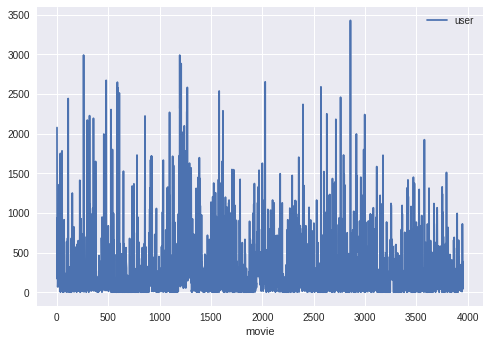

In [38]:
count_movie.plot(x ='movie',y ='user')

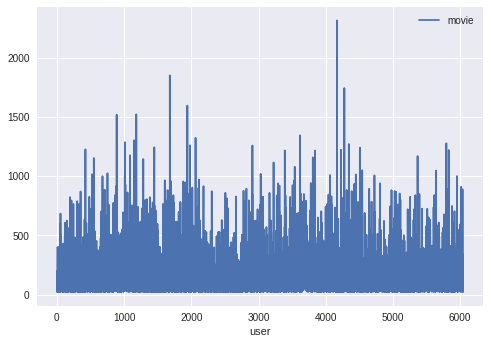

In [39]:
count_user = data.groupby('user').count()
count_user = count_user.drop('rating',axis = 1)
count_user = count_user.drop('timestamp',axis = 1).reset_index()
count_user.plot(x = 'user',y='movie')

In [12]:
count_rating = data_new.groupby('rating').count()
count_rating

,movie,user,timestamp
rating,,,
1,55836,55836,55836
2,107217,107217,107217
3,260681,260681,260681
4,348480,348480,348480
5,226055,226055,226055


In [0]:
ratings = data_new.pivot(index = "user", columns = "movie",values = "rating")
ratings = ratings.fillna(0)
ratings = ratings.as_matrix()

In [0]:
ratings_bool = ratings==0
ratings_bool = ratings_bool.astype(int)
product_count = ratings_bool.sum(axis = 1)
user_count = ratings_bool.sum(axis = 0)

In [0]:
#Storing the weights of normalization
#ratings_square = ratings.copy()
ratings_square = np.square(ratings)
row_weights = np.sqrt(ratings_square.sum(axis = 1))

#normalizing along the rows
ratings = normalize(sparse.csr_matrix(ratings), norm='l2', axis=1).todense()
ratings_square = np.square(ratings)
column_weights = np.sqrt(ratings_square.sum(axis = 0)).T

#normalizing along the columns
ratings = normalize(ratings, norm='l2', axis=0)

#converting column_weights into vector to make vector multiplication easy
column_weights_new = np.zeros(shape=(3233,))
for i in range(column_weights.shape[0]):
  column_weights_new[i] = column_weights[i,0]

In [0]:
#converting row_weights into vector to make vector multiplication easy
row_weights_new = np.zeros(shape=(6040,))
for i in range(row_weights.shape[0]):
  row_weights_new[i] = row_weights[i]

In [0]:
#Generating Similarity Matrix for Item-Item
similarities_sparse_item = cosine_similarity(ratings.T,dense_output=False)

#Generating Similarity Matrix for User-User
similarities_sparse_user = cosine_similarity(ratings,dense_output=False)

In [0]:
#predicting the ratings based on item-item similarity
predicted_ratings_item_similarity = ratings @ similarities_sparse_item
#predicting the ratings based on user-user similarity
#predicted_ratings_user_similarity = np.matmul(similarities_sparse_user.todense(),ratings.todense())
predicted_ratings_user_similarity = similarities_sparse_user @ ratings

In [0]:
#dividing by number of users or products as per necessary
predicted_ratings_user_similarity = predicted_ratings_user_similarity/user_count
predicted_ratings_item_similarity = ((predicted_ratings_item_similarity.T)/product_count).T

In [0]:
#denormalizing the predicted ratings matrix
predicted_ratings_item_similarity_denorm = (((np.array(predicted_ratings_item_similarity)*column_weights_new).T)*row_weights).T
predicted_ratings_user_similarity_denorm = (((np.array(predicted_ratings_user_similarity)*column_weights_new).T)*row_weights).T

In [0]:
#denormalizing ratings matrix
ratings_temp_row = (np.array(ratings)*column_weights_new)
ratings_denorm = (ratings_temp_row.T*row_weights_new).T

In [226]:
sum_err = 0
total_zeros = 0
count = 0

for row in ratings_denorm:
  #row = row.todense()
  temp_row = row.copy()
  non_zero_indices = row.nonzero()
  n_non_zero_indices = len(non_zero_indices[0])
  testset = random.sample(range(0,len(non_zero_indices[0])),floor(len(non_zero_indices[0])*0.3))
  for idx in testset:
    u = non_zero_indices[0][idx]
    row[u] = 0 
  new_non_zero = row.nonzero()
  zero_diff = set(non_zero_indices[0]) - set(new_non_zero[0])
  total_zeros = total_zeros + len(zero_diff)
  row_new = np.array(row)[np.newaxis]
  
  preds = predicted_ratings_item_similarity_denorm[count]
  #print(temp_row.shape)
  for i in zero_diff:
    err = (temp_row[i]-preds[i])**2
    sum_err = sum_err + err
  #if(count%50 ==0):
    #print("for count",count)
    #print(preds)
    #print(np.amax(preds))
    #print(np.argpartition(preds, -10)[0][0:10])
    #print(np.argpartition(row, -10)[0][-10:])
  count = count+1
rmse = (sum_err/total_zeros)**0.5
print(rmse)

3.643002499001647
